# library

In [1]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pydicom
import os

# Function

In [2]:
def ShowImage(title,img,ctype):
  plt.figure(figsize=(9, 9))
  if ctype=='gray':
    plt.imshow(img,cmap='gray')
  elif ctype=='rgb':
    plt.imshow(img)
  else:
    raise Exception("Unknown colour type")
  plt.axis('off')
  plt.title(title)
  plt.show()

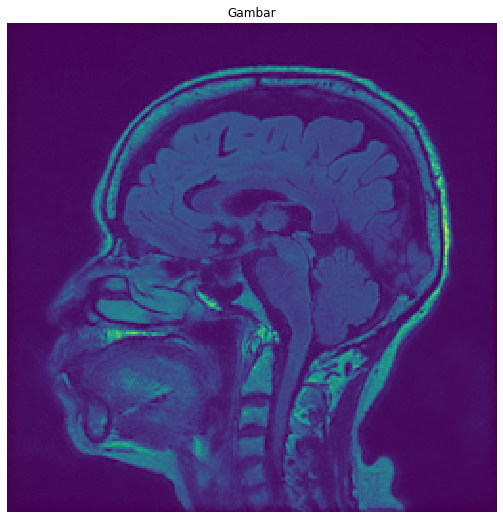

In [3]:
basepath ="../dicom/"
d = pydicom.read_file(basepath + "Z519")
file = np.array(d.pixel_array)
img = file
ShowImage('Gambar',img,'rgb')

In [4]:
img_2d = img.astype(float)
img_2d_scaled = (np.maximum(img_2d,0) / img_2d.max()) * 255.0
img_2d_scaled = np.uint8(img_2d_scaled)
hasil = img_2d_scaled

# Otsu thresholding

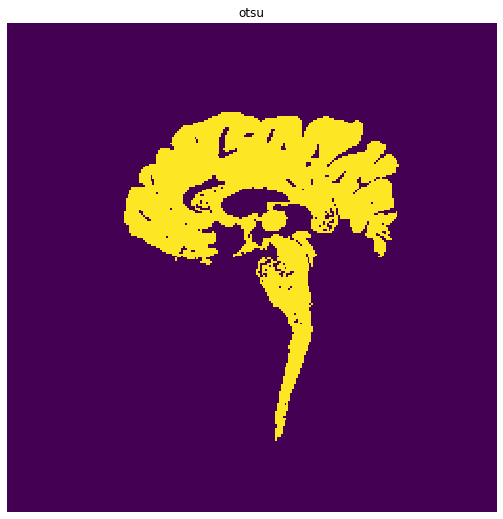

In [6]:
#OTSU THRESHOLDING
_,binarized = cv2.threshold(hasil, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

foreground_value = 255
mask_binarized = np.uint8(binarized == foreground_value)

labels, stats = cv2.connectedComponentsWithStats(mask_binarized, 4)[1:3]
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
otsu = np.zeros_like(binarized)
otsu[labels == largest_label] = foreground_value
ShowImage('otsu',otsu,'rgb')

# invers otsu

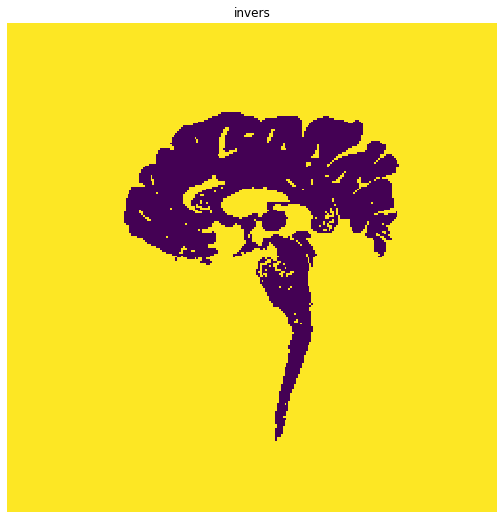

In [7]:
invers = cv2.bitwise_not(otsu)
ShowImage('invers',invers,'rgb')

# blackhat dari otsu

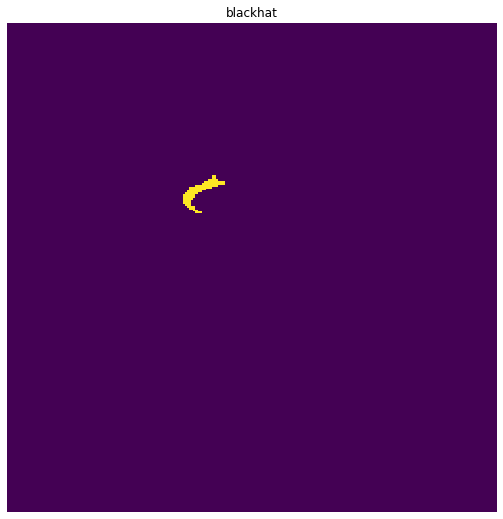

In [8]:
# blackhat
kernel = np.ones((5, 5), np.uint8)
blackhat = cv2.morphologyEx(otsu, cv2.MORPH_BLACKHAT, kernel)

foreground_value = 255
mask_gradient = np.uint8(blackhat == foreground_value)
# ShowImage('mask',mask,'rgb')

labels, stats = cv2.connectedComponentsWithStats(mask_gradient, 4)[1:3]
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
black = np.zeros_like(blackhat)
black[labels == largest_label] = foreground_value
ShowImage('blackhat',black,'rgb')

# blackhat dari otsu_invers

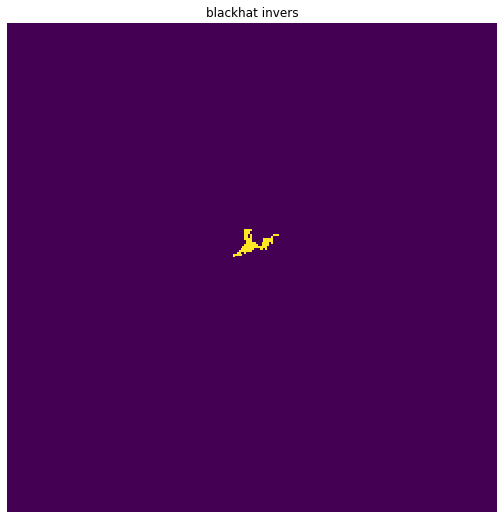

In [9]:
# blackhat
kernel = np.ones((5, 5), np.uint8)
blackhat = cv2.morphologyEx(invers, cv2.MORPH_BLACKHAT, kernel)

foreground_value = 255
mask_gradient = np.uint8(blackhat == foreground_value)
# ShowImage('mask',mask,'rgb')

labels, stats = cv2.connectedComponentsWithStats(mask_gradient, 4)[1:3]
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
black_invers = np.zeros_like(blackhat)
black_invers[labels == largest_label] = foreground_value
ShowImage('blackhat invers',black_invers,'rgb')

# dilation from blackhat

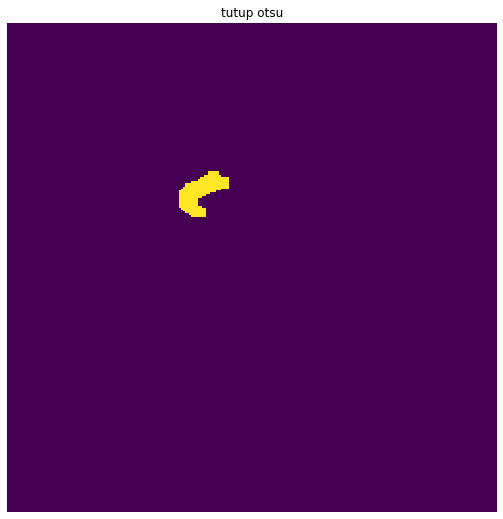

In [10]:
bentukan = np.ones((5, 5), np.uint8)
dilasi = cv2.dilate(black,bentukan,iterations = 1)

foreground_value = 255
mask_dilasi = np.uint8(dilasi >= foreground_value)
# ShowImage('mask',mask,'rgb')

labels, stats = cv2.connectedComponentsWithStats(mask_dilasi, 4)[1:3]
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
tutup_otsu = np.zeros_like(dilasi)
tutup_otsu[labels == largest_label] = foreground_value
ShowImage('tutup otsu',tutup_otsu,'rgb')


# dilation from blackhat invers

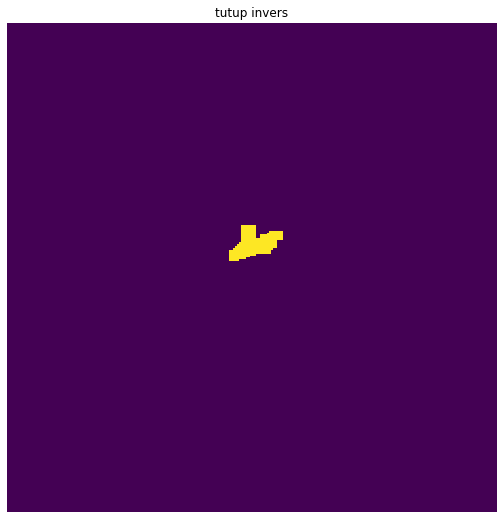

In [11]:
bentukan = np.ones((5, 5), np.uint8)
dilasi = cv2.dilate(black_invers,bentukan,iterations = 1)

foreground_value = 255
mask_dilasi = np.uint8(dilasi >= foreground_value)
# ShowImage('mask',mask,'rgb')

labels, stats = cv2.connectedComponentsWithStats(mask_dilasi, 4)[1:3]
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
tutup_invers = np.zeros_like(dilasi)
tutup_invers[labels == largest_label] = foreground_value
ShowImage('tutup invers',tutup_invers,'rgb')


# Skull Stripping

In [12]:
img_2d = file.astype(float)
img_2d_scaled = (np.maximum(img_2d,0) / img_2d.max()) * 255.0
img_2d_scaled = np.uint8(img_2d_scaled)
hasil = img_2d_scaled

#Skull Stripping
skull_stripped_image = cv2.bitwise_and(
    hasil, hasil, mask = tutup_invers)
brain_pixels = skull_stripped_image[tutup_invers == foreground_value]
print (brain_pixels, 'Brain Pixels')

# Adapting the data to K-means
kmeans_input = np.float32(brain_pixels.reshape(
    brain_pixels.shape[0], brain_pixels.ndim))
print(kmeans_input, 'Kmeans Input')

# K-means parameters
epsilon = 0.01
number_of_iterations = 50
number_of_clusters = 4
number_of_repetition = 10
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,
            number_of_iterations, epsilon)
flags = cv2.KMEANS_RANDOM_CENTERS
print(criteria, 'criteria Paramaters')

# K-means segmentation
_, labels, centers = cv2.kmeans(
    kmeans_input, number_of_clusters, None, criteria,
    number_of_repetition, flags)
print(labels.shape, 'K-means segmentation')

# Adapting the labels
labels = labels.flatten('F')
for x in range(number_of_clusters):
    labels[labels == x] = centers[x]

[51 58 64 58 47 56 66 45 43 48 57 60 53 60 57 25 36 39 56 70 58 44 30 23
 28 34 58 71 58 32 32 35 15 22 17 14 19 19 16 25 26 55 71 44 40 37 33 16
 13 26 24 17 13 12  8 25 21 44 54 37 51 40 25 28 27 22 28 27 25 33 43 56
 43 11  6 26 22 43 46 37 50 40 27 28 28 27 33 29 35 43 60 66 51 45 43 18
 19 46 51 47 48 37 31 29 28 27 37 51 55 59 59 56 65 67 62 52 61 19 24 39
 41 50 46 39 36 33 39 36 31 50 61 60 53 56 56 52 27 20 24 34 43 58 60 57
 47 35 30 35 48 58 57 46 26 46 54 49 16 21 20 28 51 62 63 59 63 51 42 32
 38 52 58 65 42 27 25 41 61 22 17 23 35 51 61 66 61 65 70 67 54 43 51 44
 42 54 36 26 26 30 48 20 28 26 39 62 61 66 69 72 67 49 39 32 26 44 41 37
 43 36 32 26 17 18 21 29 37 50 59 50 54 56 52 41 30 24 21 22 19 26 27 25
 24 27 14 25 26 29 44 47 39 36 45 36 21 34 31 19 16 22 18 20 21 22 24 26
 34 35 42 43 44 44 42 34 20 21 21 25 25 18 37 36 47 34 28 28 22 16 19 16
 17 38 27 24 21 32 27 19 16 20 16 19 22 31 34] Brain Pixels
[[51.]
 [58.]
 [64.]
 [58.]
 [47.]
 [56.]
 [66.]
 [45.]
 [43.]
 

# Segmented image

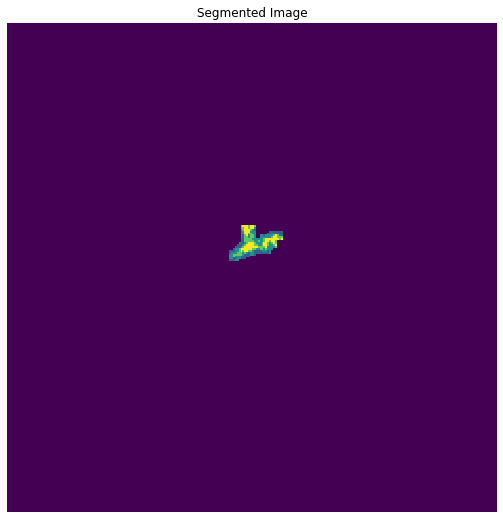

In [13]:
segmented_image = np.zeros_like(tutup_invers)
segmented_image[tutup_invers == foreground_value] = labels
ShowImage('Segmented Image',segmented_image,'rgb')

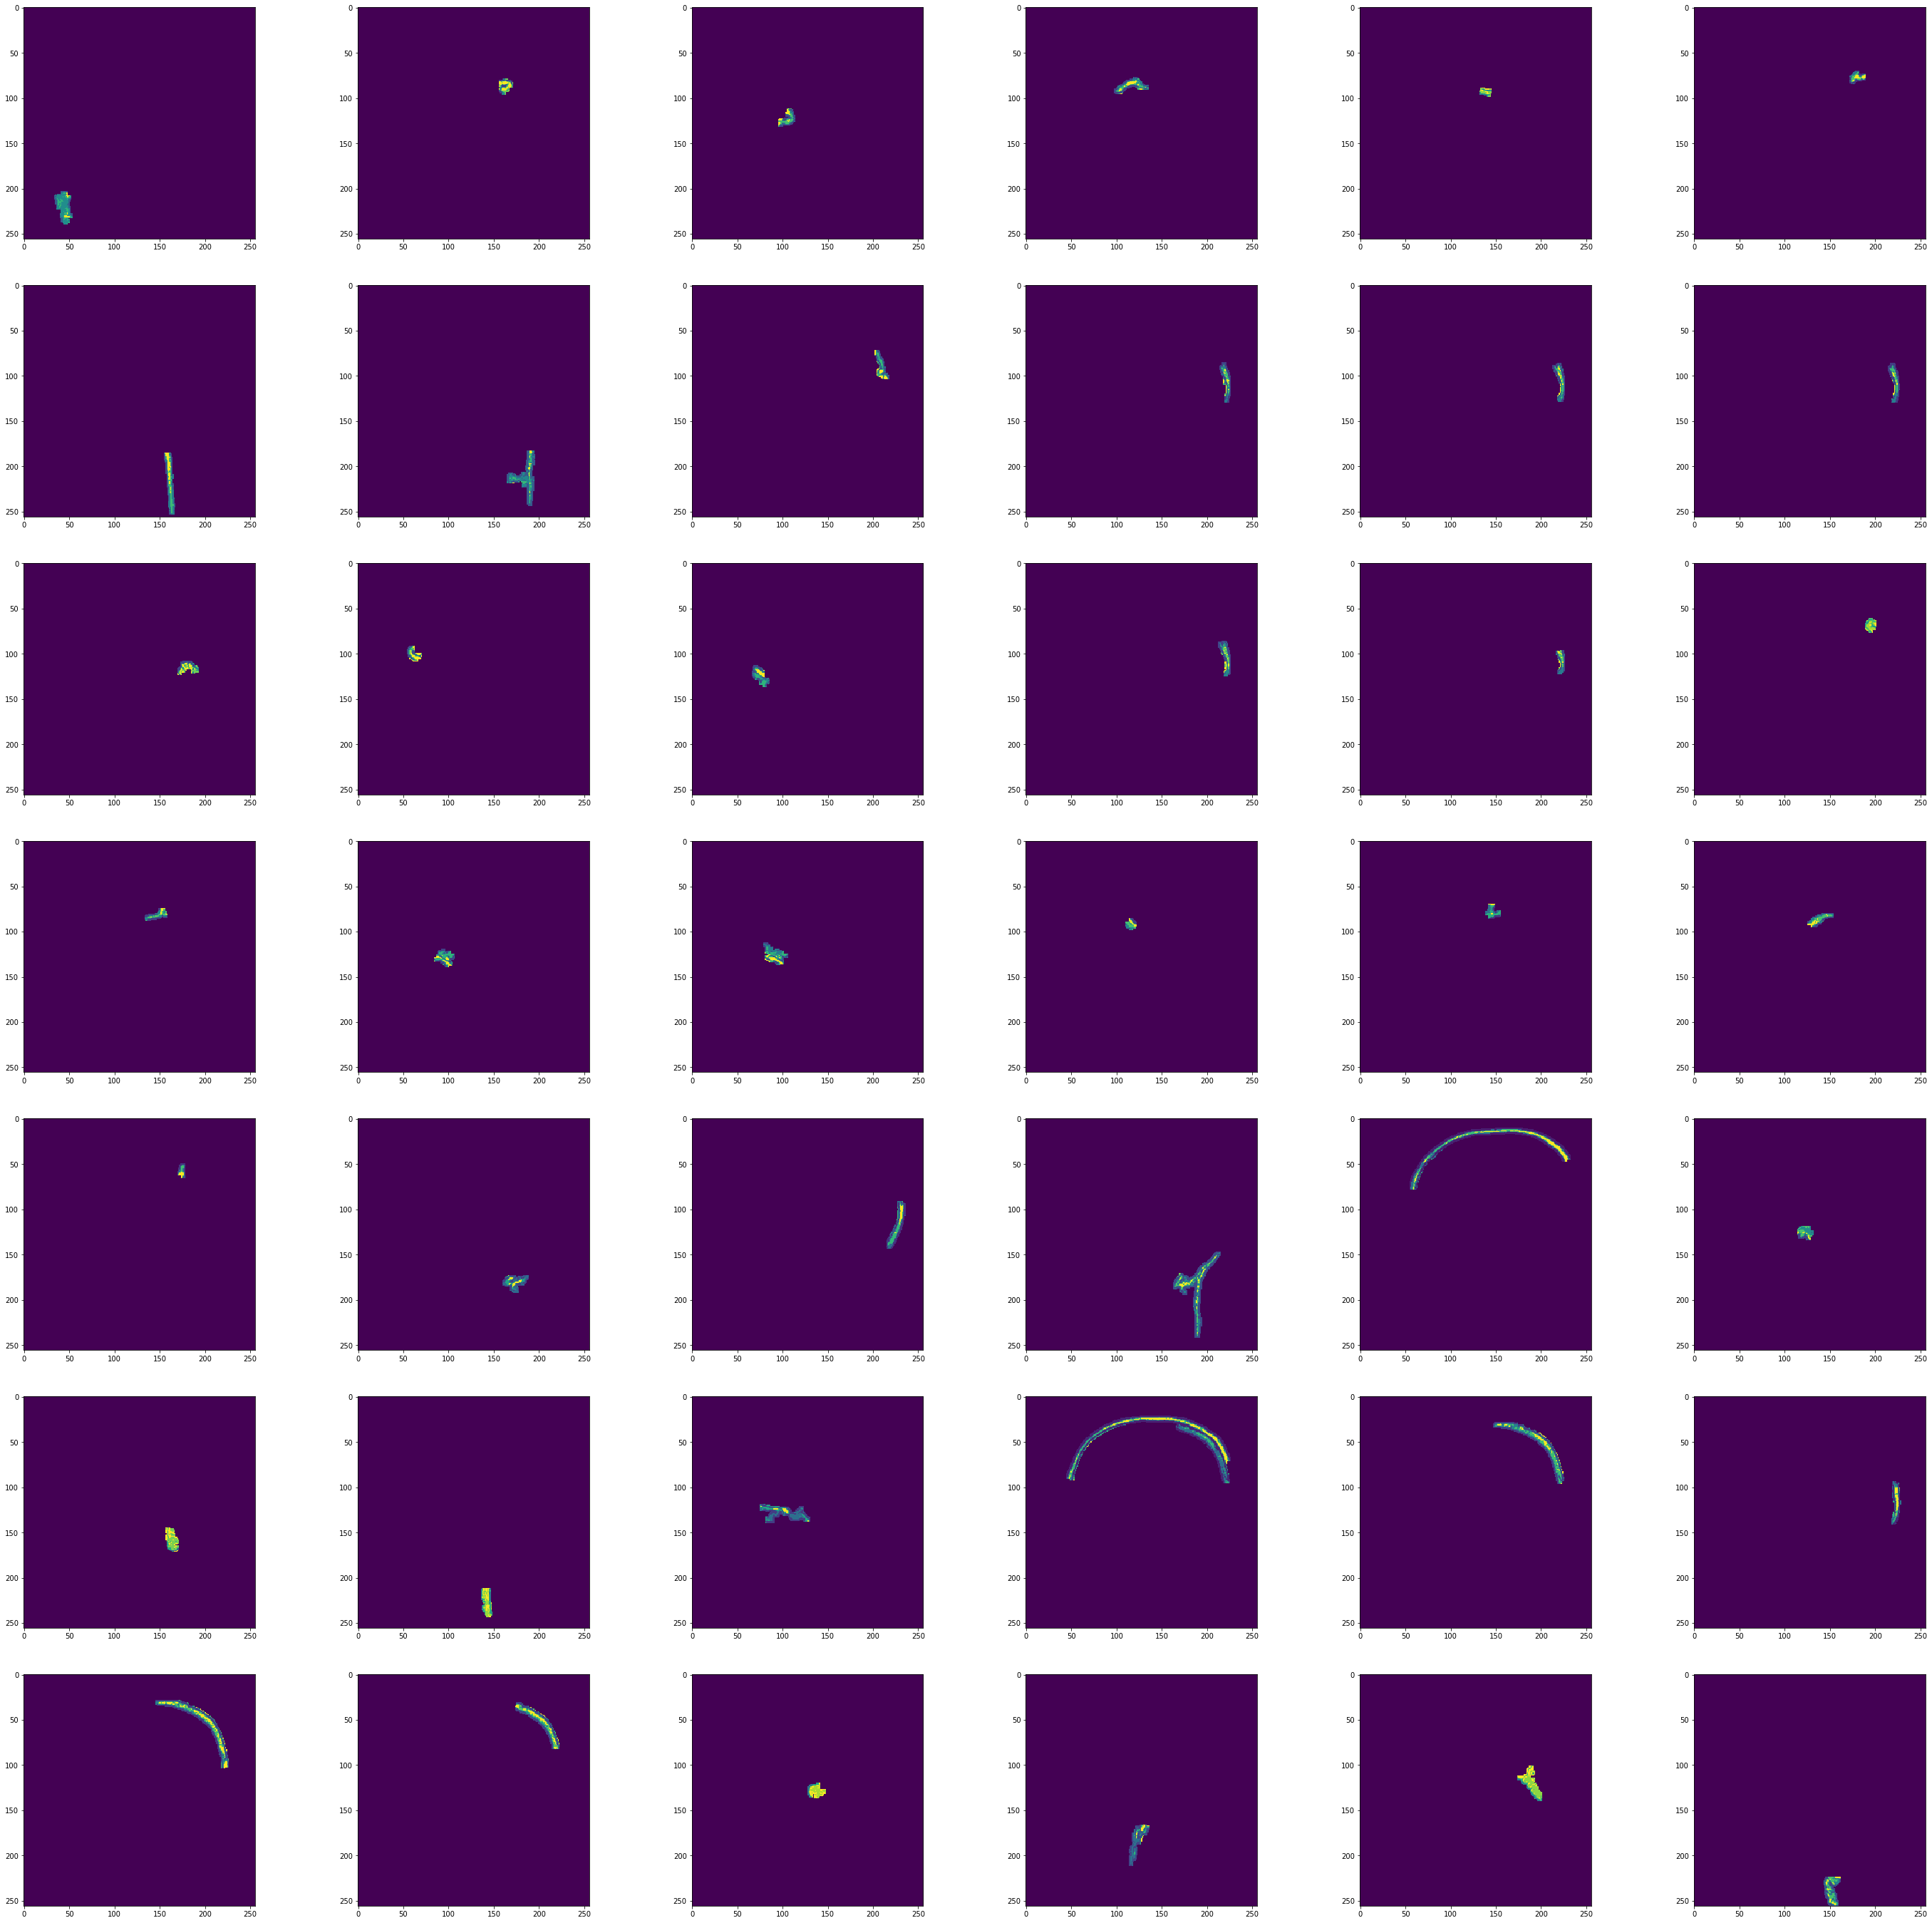

In [19]:
basepath ="../dicom/"
IMAGE_PATHS = os.listdir("../dicom/")
list_a = []

for f in IMAGE_PATHS:
    d = pydicom.read_file(basepath+f)
    a = np.array(d.pixel_array)
    
    img_2d = a.astype(float)
    img_2d_scaled = (np.maximum(img_2d,0) / img_2d.max()) * 255.0
    img_2d_scaled = np.uint8(img_2d_scaled)
    hasil = img_2d_scaled
    
    #OTSU THRESHOLDING
    _,binarized = cv2.threshold(hasil, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    foreground_value = 255
    mask_binarized = np.uint8(binarized == foreground_value)

    labels, stats = cv2.connectedComponentsWithStats(mask_binarized, 4)[1:3]
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    otsu = np.zeros_like(binarized)
    otsu[labels == largest_label] = foreground_value
    
    invers = cv2.bitwise_not(otsu)
    
    # blackhat
    kernel = np.ones((5, 5), np.uint8)
    blackhat = cv2.morphologyEx(invers, cv2.MORPH_BLACKHAT, kernel)

    foreground_value = 255
    mask_gradient = np.uint8(blackhat == foreground_value)

    labels, stats = cv2.connectedComponentsWithStats(mask_gradient, 4)[1:3]
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    black_invers = np.zeros_like(blackhat)
    black_invers[labels == largest_label] = foreground_value
    
    bentukan = np.ones((5, 5), np.uint8)
    dilasi = cv2.dilate(black_invers,bentukan,iterations = 1)

    foreground_value = 255
    mask_dilasi = np.uint8(dilasi >= foreground_value)

    labels, stats = cv2.connectedComponentsWithStats(mask_dilasi, 4)[1:3]
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    tutup_invers = np.zeros_like(dilasi)
    tutup_invers[labels == largest_label] = foreground_value
    

    #Skull Stripping
    skull_stripped_image = cv2.bitwise_and(hasil, hasil, mask = tutup_invers)
    brain_pixels = skull_stripped_image[tutup_invers == foreground_value]

    # Adapting the data to K-means
    kmeans_input = np.float32(brain_pixels.reshape(brain_pixels.shape[0], brain_pixels.ndim))

    # K-means parameters
    epsilon = 0.01
    number_of_iterations = 50
    number_of_clusters = 4
    number_of_repetition = 10
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,number_of_iterations, epsilon)
    flags = cv2.KMEANS_RANDOM_CENTERS

    # K-means segmentation
    _, labels, centers = cv2.kmeans(kmeans_input, number_of_clusters, None, criteria,number_of_repetition, flags)

    # Adapting the labels
    labels = labels.flatten('F')
    for x in range(number_of_clusters):
        labels[labels == x] = centers[x]
        
    segmented_image = np.zeros_like(tutup_invers)
    segmented_image[tutup_invers == foreground_value] = labels
    
    list_a.append(segmented_image)
    
fig=plt.figure(figsize=(49, 49))
columns = 6
rows = 7
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(list_a[i])
plt.show()